In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import random_correlation
from numpy.random import default_rng

In [107]:
class SimulatedDataset:

    '''
    description
    '''
    def __init__(self, N,  d, alpha, seed=123):
        self.rng = default_rng(seed)
        self.N = N
        self.d = d
        self.alpha = alpha

        self.X = self.generate_features()
        self.x_confounders_idx, self.x_prognostic_idx,  self.x_effect_mod_idx = self.set_covariate_types()

        self.mu0 = self.set_mu0()
        self.tau = self.set_tau()
        self.mu1 = self.set_mu1()
        self.e = self.set_propensity_fn()
        self.Y0, self.Y1 = self.generate_potential_outcomes()

        self.W = self.generate_treatment()
        self.Y = self.generate_outcome()
        
    # --------------------------
    # CORRELATION STRUCTURE

    def generate_random_eigenvector(self):
        eigvals = self.rng.dirichlet(np.ones(self.d)) * self.d
        return eigvals

    def generate_random_correlation_matrix(self):
        eigvals = self.generate_random_eigenvector()
        corr_matrix = random_correlation.rvs(eigvals, random_state=self.rng)
        return corr_matrix

    def generate_features(self):
        corr_matrix = self.generate_random_correlation_matrix()
        X = self.rng.multivariate_normal(mean=np.zeros(self.d), cov=corr_matrix, size=self.N)
        return X
    
    def set_covariate_types(self):
        x_confounders_idx = [0, 1, 2, 3]
        x_prognostic_idx = [4, 5, 6]
        x_effect_mod_idx = [7, 8, 9]
        return x_confounders_idx, x_prognostic_idx, x_effect_mod_idx

    # --------------------------
    # STRUCTURAL FUNCTIONS

    def rho(self, x):
        # example heterogeneity function
        return 2 / (1 + np.exp(-5 * (x - 0.35)))

    def set_mu0(self):
        # function of confounding and prognostic covariates
        Xc = self.X[:, self.x_confounders_idx]
        Xp = self.X[:, self.x_prognostic_idx]

        mu0 = (
            0.6 * Xc[:, 0]
            - 0.3 * Xc[:, 1]
            + 0.2 * Xc[:, 2]
            - 0.1 * Xc[:, 3]**2
            + 0.5 * Xp[:, 0]
            - 0.2 * Xp[:, 1]
            + 0.1 * Xp[:, 2]**2
        )
        return mu0
    
    def set_tau(self):
        # function of effect modifier covariates
        Xem = self.X[:, self.x_effect_mod_idx]
        tau = (
            0.8 * self.rho(Xem[:, 0])
            - 0.4 * self.rho(Xem[:, 1])
            + 0.2 * self.rho(Xem[:, 2]**2)
        )
        return tau
        

    def set_mu1(self):
        # mu1 = mu0 + tau
        return self.mu0 + self.set_tau()

    def generate_potential_outcomes(self):
        eps = self.rng.normal(0, 1, size=self.N)
        Y0 = self.mu0 + eps
        Y1 = self.mu1 + eps
        return Y0, Y1

    def set_propensity_fn(self):
        '''
        Propensity score function determining probability of treatment = 1
            e(x) = P(W=1|X=x),
        with 'alpha' controlling strength of confounding
        (alpha = 0 is completely random treatment assignment)
        '''
        Xc = self.X[:, self.x_confounders_idx]
        logits = (
            0.6 * Xc[:, 0]
            - 0.4 * Xc[:, 1]
            + 0.2 * Xc[:, 2]
            - 0.1 * Xc[:, 3]**2
        )
        return 1 / (1 + np.exp(-logits*self.alpha + 0.35))

    # -------------------------
    # OUTCOME AND TREATMENT

    def generate_treatment(self):
        return self.rng.binomial(1, self.e)

    def generate_outcome(self):
        return np.where(self.W == 1, self.Y1, self.Y0)

In [110]:
sample_dataset = SimulatedDataset(1000, 15, 0.5)
sample_dataset.X

array([[-1.36230278, -0.26890998,  1.13756331, ..., -0.30514846,
        -0.40281048,  0.20908563],
       [-1.47920913, -0.16774961,  0.79025782, ...,  0.79372678,
         0.37625533,  1.72699539],
       [-0.16325267,  0.66990051,  0.21617797, ..., -1.74365724,
        -0.33228718,  0.39501121],
       ...,
       [ 1.4916272 ,  0.55816143,  0.7566697 , ...,  1.36541427,
         0.24287191, -0.69781382],
       [ 0.13508699, -0.19869365,  1.11037978, ..., -1.06387302,
        -0.48626369,  0.72711138],
       [ 1.56551296, -0.17609425, -0.52676113, ...,  1.06714915,
        -0.86268131,  0.39017408]], shape=(1000, 15))

In [111]:

n_treated = sample_dataset.W.sum()
n_control = len(sample_dataset.W) - n_treated
print(n_control, n_treated)

613 387


(array([ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,  1.,  3.,  2.,
         2.,  0.,  4.,  2.,  4.,  3.,  7.,  4.,  4.,  9.,  6.,  5.,  8.,
        10.,  6.,  9., 13., 13., 14., 15., 12., 20., 18., 26., 18., 15.,
        21., 21., 14., 25., 17., 28., 19., 21., 24., 23., 18., 19., 27.,
        26., 23., 19., 33., 26., 16., 11., 14., 22., 27., 17., 13., 11.,
        11., 15.,  7., 14., 17., 13., 15., 13.,  8., 11., 12.,  4.,  4.,
         5., 10.,  2.,  2.,  4.,  4.,  2.,  7.,  4.,  1.,  5.,  4.,  2.,
         2.,  1.,  2.,  1.,  1.,  1.,  0.,  1.,  1.]),
 array([0.15148697, 0.1564403 , 0.16139364, 0.16634697, 0.17130031,
        0.17625364, 0.18120698, 0.18616031, 0.19111365, 0.19606698,
        0.20102032, 0.20597365, 0.21092698, 0.21588032, 0.22083365,
        0.22578699, 0.23074032, 0.23569366, 0.24064699, 0.24560033,
        0.25055366, 0.255507  , 0.26046033, 0.26541367, 0.270367  ,
        0.27532034, 0.28027367, 0.285227  , 0.29018034, 0.29513367,
        0.30008701, 0.3050

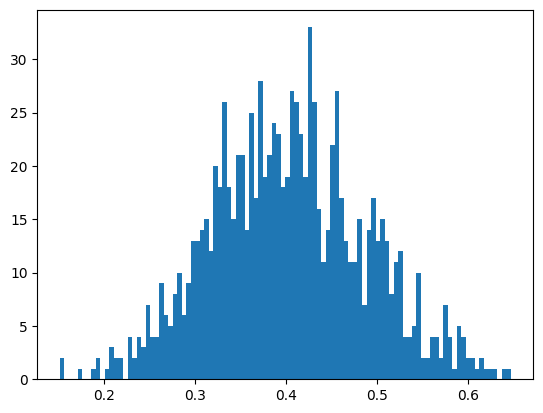

In [112]:
np.min(sample_dataset.e), np.max(sample_dataset.e)
plt.hist(sample_dataset.e, bins=100)


In [113]:
sample_dataset.x_confounders_idx, sample_dataset.x_prognostic_idx, sample_dataset.x_effect_mod_idx

([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])

In [114]:
sample_dataset.tau

array([ 7.62904958e-01,  1.45684031e+00,  3.93100996e-01,  1.09096251e+00,
        1.17157395e+00,  1.52549316e+00,  1.78771040e+00,  6.10225106e-01,
        1.32983938e-01,  4.26216437e-01,  4.05083072e-01,  1.51937455e+00,
        7.94052559e-01,  2.89349777e-01,  3.00126222e-01,  8.60059757e-01,
        1.22304916e+00,  1.22193226e+00,  3.79566356e-01,  5.83979599e-01,
        1.55140965e+00, -6.41209671e-01,  3.26569878e-01, -3.88565870e-01,
        5.53825672e-01, -1.50270595e-01, -6.63108074e-01,  1.08794392e+00,
        1.64407924e+00,  1.33815313e-01,  6.34193576e-01,  2.19026876e-01,
        1.15011006e+00,  7.33357995e-02,  1.75478397e+00,  1.39851861e+00,
       -1.96925113e-01, -5.66116057e-01,  1.83727908e+00,  1.97600373e+00,
        4.47047999e-01,  1.59962276e+00,  1.10727499e-02, -6.36428419e-01,
       -3.41557956e-01,  1.96547672e+00,  9.27152562e-01,  2.97458813e-01,
       -6.57319493e-01, -2.74120972e-01,  1.22486210e-01, -3.73275790e-02,
        1.13628852e+00,  